# Bírósági Határozatok - Exploratív Adatanalízis (EDA)

Ez a notebook a `preprocess_documents.py` által generált `raw_data_for_eda.csv` fájl tartalmát elemzi.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import sys
import os
import json # Added for handling JSON strings

# Projekt gyökér meghatározása és hozzáadása a sys.path-hoz
project_root = Path(os.getcwd()).resolve().parent # Assuming notebook is in 'notebooks' subdir
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Konfiguráció importálása
try:
    from configs import config
except ImportError:
    print("Hiba: A config.py nem található vagy nem importálható.")
    # Fallback path if config import fails
    DATA_PATH = project_root / 'processed_data' / 'raw_data_for_eda.csv'
else:
    DATA_PATH = config.RAW_CSV_DATA_PATH

# Matplotlib beállítások
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

OpenAI API Key loaded successfully from environment.
Konfiguráció betöltve. Projekt gyökér: /Users/zelenyianszkimate/Documents/Szakdolgozat
Adat könyvtár: /Users/zelenyianszkimate/Documents/Szakdolgozat/data
Kimeneti könyvtár: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data
Nyers adat CSV: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/raw_data_for_eda.csv
Tisztított adat CSV: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/cleaned_data_for_embedding.csv
Feldolgozott Parquet: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/processed_documents_with_embeddings.parquet
OpenAI Embedding modell: text-embedding-3-small


## 1. Adatok Betöltése

In [2]:
print(f"Adatok betöltése innen: {DATA_PATH}")
if not DATA_PATH.exists():
    print(f"Hiba: A fájl nem található: {DATA_PATH}")
    print("Kérlek, futtasd először a preprocess_documents.py szkriptet.")
else:
    try:
        df = pd.read_csv(DATA_PATH, encoding=config.CSV_ENCODING if 'config' in locals() else 'utf-8')
        print(f"{len(df)} dokumentum betöltve.")

        # Oszlopok eldobása
        columns_to_drop = ['Rezume', 'IndexelesIdeje', 'IndexId']
        existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
        if existing_columns_to_drop:
            df.drop(columns=existing_columns_to_drop, inplace=True)
            print(f"Eltávolított oszlopok: {existing_columns_to_drop}")
        else:
            print("A megadott oszlopok ('Rezume', 'IndexelesIdeje', 'IndexId') egyike sem található.")

        # Oszlopok átnevezése
        rename_mapping = {
            'AllKapcsolodoUgyszam': 'Kapcsolódó Ügyszám',
            'AllKapcsolodoBirosag': 'Kapcsolódó Bíróság'
        }
        # Csak a létező oszlopokat nevezzük át
        existing_rename_mapping = {k: v for k, v in rename_mapping.items() if k in df.columns}
        if existing_rename_mapping:
            df.rename(columns=existing_rename_mapping, inplace=True)
            print(f"Átnevezett oszlopok: {existing_rename_mapping}")
        else:
            print("Az átnevezendő oszlopok ('AllKapcsolodoUgyszam', 'AllKapcsolodoBirosag') egyike sem található.")

        print(f"Megmaradt oszlopok: {df.columns.tolist()}")
    except Exception as e:
        print(f"Hiba a CSV olvasása vagy feldolgozása közben: {e}")

Adatok betöltése innen: /Users/zelenyianszkimate/Documents/Szakdolgozat/processed_data/raw_data_for_eda.csv
216642 dokumentum betöltve.
Eltávolított oszlopok: ['Rezume', 'IndexelesIdeje', 'IndexId']
Átnevezett oszlopok: {'AllKapcsolodoUgyszam': 'Kapcsolódó Ügyszám', 'AllKapcsolodoBirosag': 'Kapcsolódó Bíróság'}
Megmaradt oszlopok: ['doc_id', 'text', 'birosag', 'JogTerulet', 'Azonosito', 'MeghozoBirosag', 'EgyediAzonosito', 'HatarozatEve', 'Kapcsolódó Ügyszám', 'Kapcsolódó Bíróság', 'KapcsolodoHatarozatok', 'Jogszabalyhelyek', 'Kollegium']


## 2. Alapvető Információk és Statisztikák

In [3]:
if 'df' in locals():
    print("Adatkeret mérete (sorok, oszlopok):", df.shape)
    print("\nElső 5 sor:")
    display(df.head())
    print("\nAdattípusok és nem-null értékek:")
    df.info()
    print("\nLeíró statisztikák (numerikus oszlopok):")
    display(df.describe())
    print("\nLeíró statisztikák (kategorikus és egyéb oszlopok):")
    display(df.describe(include=['object', 'boolean']))

Adatkeret mérete (sorok, oszlopok): (216642, 13)

Első 5 sor:


,doc_id,text,birosag,JogTerulet,Azonosito,MeghozoBirosag,EgyediAzonosito,HatarozatEve,Kapcsolódó Ügyszám,Kapcsolódó Bíróság,KapcsolodoHatarozatok,Jogszabalyhelyek,Kollegium
0,Bf.262/2011/12,"A Pécsi Ítélőtábla, mint másodfokú bíróság Bf....",Pécsi Ítélőtábla,büntetőjog,Bf.262/2011/12,Pécsi Ítélőtábla,PIT-BJ-2011-66,2011.0,"[""B.54/2010/26""]","[""Szekszárdi Törvényszék""]","[{""KapcsolodoUgyszam"": ""B.54/2010/26"", ""Kapcso...",1998. évi XIX. törvény a büntetőeljárásról 348...,büntető
1,Bf.34/2015/29,"A Pécsi Ítélőtábla, mint másodfokú bíróság Bf....",Pécsi Ítélőtábla,büntetőjog,Bf.34/2015/29,Pécsi Ítélőtábla,PIT-BJ-2016-36,2016.0,"[""B.11/2014/18""]","[""Zalaegerszegi Törvényszék""]","[{""KapcsolodoUgyszam"": ""B.11/2014/18"", ""Kapcso...",1998. évi XIX. törvény a büntetőeljárásról 335...,büntető
2,Bf.111/2007/8,"A Pécsi Ítélőtábla, mint másodfokú bíróság Bf....",Pécsi Ítélőtábla,büntetőjog,Bf.111/2007/8,Pécsi Ítélőtábla,PIT-BJ-2007-25,2007.0,"[""Bhar.966/2007/10"", ""B.185/2006/18""]","[""Kúria"", ""Szekszárdi Törvényszék""]","[{""KapcsolodoUgyszam"": ""Bhar.966/2007/10"", ""Ka...",1998. évi XIX. törvény a büntetőeljárásról 351...,büntető
3,Bf.95/2014/10,"A Pécsi Ítélőtábla, mint másodfokú bíróság Bf....",Pécsi Ítélőtábla,büntetőjog,Bf.95/2014/10,Pécsi Ítélőtábla,PIT-BJ-2015-24,2015.0,"[""B.226/2012/189""]","[""Pécsi Törvényszék""]","[{""KapcsolodoUgyszam"": ""B.226/2012/189"", ""Kapc...",1978. évi IV. törvény a Büntető Törvénykönyvrő...,büntető
4,Bhar.181/2012/8,"A Pécsi Ítélőtábla, mint harmadfokú bíróság Bh...",Pécsi Ítélőtábla,büntetőjog,Bhar.181/2012/8,Pécsi Ítélőtábla,PIT-BJ-2012-82,2012.0,"[""Bf.1/2012/3"", ""B.151/2011/8""]","[""Szekszárdi Törvényszék"", ""Tamási Járásbíróság""]","[{""KapcsolodoUgyszam"": ""Bf.1/2012/3"", ""Kapcsol...",1998. évi XIX. törvény a büntetőeljárásról 387...,büntető



Adattípusok és nem-null értékek:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216642 entries, 0 to 216641
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   doc_id                 216642 non-null  object 
 1   text                   216625 non-null  object 
 2   birosag                216642 non-null  object 
 3   JogTerulet             216359 non-null  object 
 4   Azonosito              216360 non-null  object 
 5   MeghozoBirosag         216360 non-null  object 
 6   EgyediAzonosito        216360 non-null  object 
 7   HatarozatEve           216360 non-null  float64
 8   Kapcsolódó Ügyszám     177052 non-null  object 
 9   Kapcsolódó Bíróság     177052 non-null  object 
 10  KapcsolodoHatarozatok  177052 non-null  object 
 11  Jogszabalyhelyek       216288 non-null  object 
 12  Kollegium              216360 non-null  object 
dtypes: float64(1), object(12)
memory usage: 21.5+ MB

Leíró

,HatarozatEve
count,216360.000000
mean,2014.867799
std,5.181282
min,1989.000000
25%,2010.000000
50%,2015.000000
75%,2019.000000
max,2025.000000



Leíró statisztikák (kategorikus és egyéb oszlopok):


,doc_id,text,birosag,JogTerulet,Azonosito,MeghozoBirosag,EgyediAzonosito,Kapcsolódó Ügyszám,Kapcsolódó Bíróság,KapcsolodoHatarozatok,Jogszabalyhelyek,Kollegium
count,216642,216625,216642,216359,216360,216360,216360,177052,177052,177052,216288,216360
unique,213419,216599,186,8,213137,159,214104,174448,1389,175533,215649,33
top,Pf.20009/2024/4,<html><body><h1>504 Gateway Time-out</h1>The s...,Kúria,polgári jog,Pf.20009/2024/4,Kúria,DIT-BJ-2020-4,"[""Pf.20966/2009/4""]","[""Fővárosi Törvényszék""]","[{""KapcsolodoUgyszam"": ""Pf.21041/2010/3"", ""Kap...",1952. évi III. törvény a polgári perrendtartás...,polgári
freq,4,12,49441,84840,4,49441,2,4,22238,2,14,88508


## 3. Hiányzó Értékek Elemzése

Hiányzó értékek oszloponként:


,Darabszám,Százalék
Kapcsolódó Ügyszám,39590,18.274388
Kapcsolódó Bíróság,39590,18.274388
KapcsolodoHatarozatok,39590,18.274388
Jogszabalyhelyek,354,0.163403
JogTerulet,283,0.130630
Azonosito,282,0.130169
MeghozoBirosag,282,0.130169
EgyediAzonosito,282,0.130169
HatarozatEve,282,0.130169
Kollegium,282,0.130169


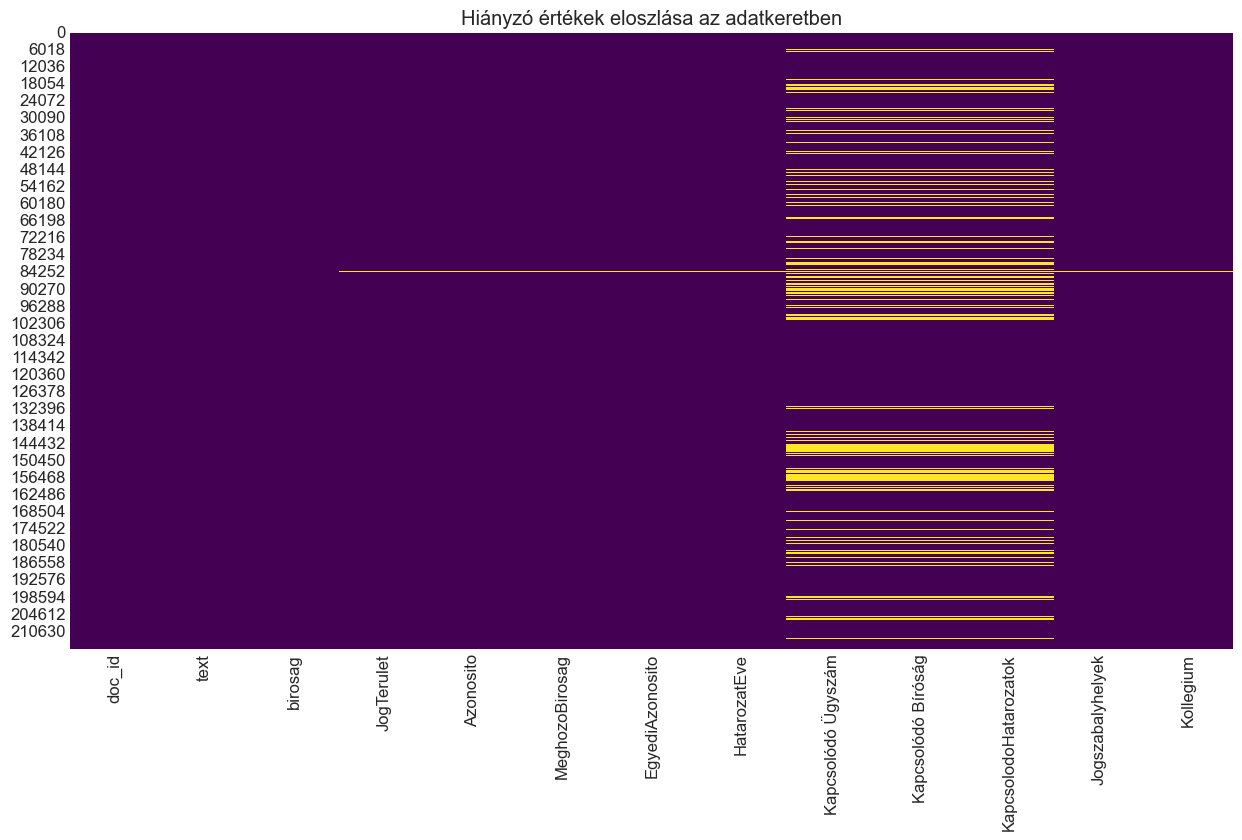

In [4]:
if 'df' in locals():
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({'Darabszám': missing_values, 'Százalék': missing_percent})
    missing_df = missing_df[missing_df['Darabszám'] > 0].sort_values(by='Százalék', ascending=False)

    print("Hiányzó értékek oszloponként:")
    display(missing_df)

    # Hiányzó értékek vizualizációja (heatmap)
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Hiányzó értékek eloszlása az adatkeretben')
    plt.show()

## 4. Szövegelemzés

Szöveghossz statisztikák (karakterek):


count    2.166420e+05
mean     2.618263e+04
std      3.353447e+04
min      0.000000e+00
25%      1.288100e+04
50%      1.936050e+04
75%      2.986100e+04
max      1.578577e+06
Name: text_length, dtype: float64


Az adatok 99%-a 126091 karakternél rövidebb szöveget tartalmaz.
A hisztogram csak ezeket az adatokat mutatja ( 214475 db ).


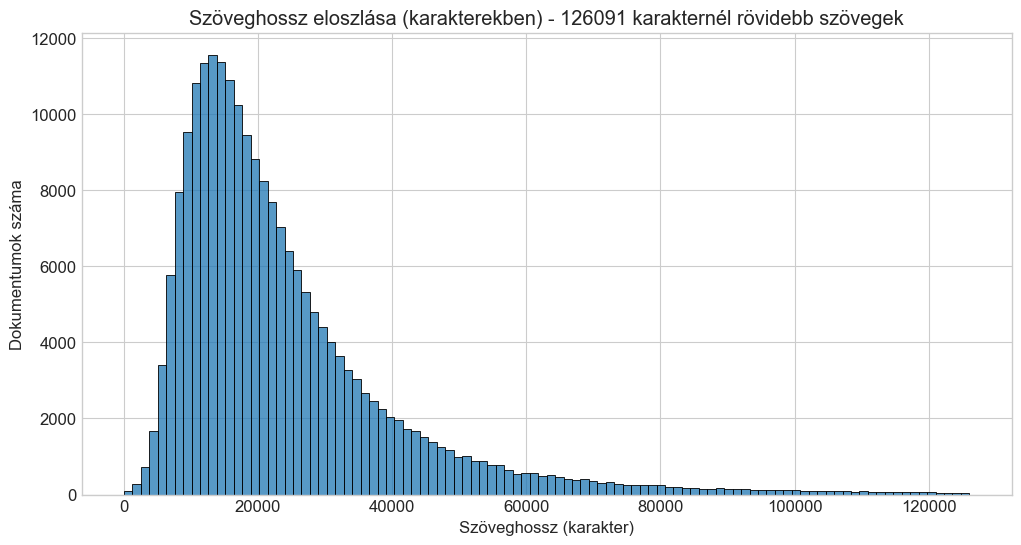


21 db 50 karakternél rövidebb dokumentum található.
Példák rövid szövegekre (max 10):


,doc_id,text,text_length
8718,G.20023/2022/117,NaN,0
16474,B.246/2012/1014,NaN,0
25441,P.102585/2014/1,NaN,0
44140,Kfv.37702/2010/6,Kfv.II.37.702/2010/6.szám,25
47366,Kfv.37605/2010/4,Kfv.II.37.605/2010/4.szám,25
57612,Kfv.37589/2010/4,Kfv.II.37.589/2010/4.szám,25
150663,B.213/2014/213,NaN,0
151168,B.336/2023/25,NaN,0
161453,B.774/2007/510,Fővárosi Törvényszék 17.B.774/2007/510.,39
162540,B.311/2015/517,NaN,0



17 db üres szövegű dokumentum található.
Példák üres szövegekre (max 10):


,doc_id,text_length
8718,G.20023/2022/117,0
16474,B.246/2012/1014,0
25441,P.102585/2014/1,0
150663,B.213/2014/213,0
151168,B.336/2023/25,0
162540,B.311/2015/517,0
163304,B.794/2010/828,0
181631,Kb.393/2013/261,0
182254,G.43587/2014/6,0
182837,G.44559/2014/4,0


In [5]:
if 'df' in locals() and 'text' in df.columns:
    # Szöveghossz számítása (karakterekben)
    df['text_length'] = df['text'].fillna('').astype(str).apply(len)

    print("Szöveghossz statisztikák (karakterek):")
    display(df['text_length'].describe())

    # Kiugró értékek szűrése a jobb vizualizáció érdekében
    # Például a 99. percentilis alatti értékek megjelenítése
    quantile_99 = df['text_length'].quantile(0.99)
    df_filtered_length = df[df['text_length'] < quantile_99]
    print(f"\nAz adatok 99%-a {quantile_99:.0f} karakternél rövidebb szöveget tartalmaz.")
    print(f"A hisztogram csak ezeket az adatokat mutatja ( {len(df_filtered_length)} db ).")

    # Szöveghossz eloszlás vizualizáció (szűrt adatokon)
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_filtered_length, x='text_length', bins=100, kde=False)
    plt.title(f'Szöveghossz eloszlása (karakterekben) - {quantile_99:.0f} karakternél rövidebb szövegek')
    plt.xlabel('Szöveghossz (karakter)')
    plt.ylabel('Dokumentumok száma')
    plt.grid(True)
    plt.show()

    # Rövid szövegek vizsgálata
    short_text_threshold = 50
    short_texts = df[df['text_length'] < short_text_threshold]
    print(f"\n{len(short_texts)} db {short_text_threshold} karakternél rövidebb dokumentum található.")
    if not short_texts.empty:
        print(f"Példák rövid szövegekre (max 10):")
        display(short_texts[['doc_id', 'text', 'text_length']].head(10))

    # Üres szövegek vizsgálata
    empty_texts = df[df['text_length'] == 0]
    print(f"\n{len(empty_texts)} db üres szövegű dokumentum található.")
    if not empty_texts.empty:
        print(f"Példák üres szövegekre (max 10):")
        display(empty_texts[['doc_id', 'text_length']].head(10))

## 5. Kategorikus Változók Elemzése


'birosag' egyedi értékeinek száma: 130
Leggyakoribb 30 érték:


birosag
Kúria                                                   49441
Fővárosi Törvényszék                                    34428
Fővárosi Ítélőtábla                                     31997
Budapest Környéki Törvényszék                            8837
Debreceni Ítélőtábla                                     7130
Győri Ítélőtábla                                         6204
Szegedi Ítélőtábla                                       5787
Debreceni Törvényszék                                    5641
Szegedi Törvényszék                                      5083
Pécsi Ítélőtábla                                         4461
Miskolci Törvényszék                                     4359
Fővárosi Közigazgatási és Munkaügyi Bíróság              3701
Győri Törvényszék                                        3412
Veszprémi Törvényszék                                    3035
Pécsi Törvényszék                                        2828
Kecskeméti Törvényszék                                   2679


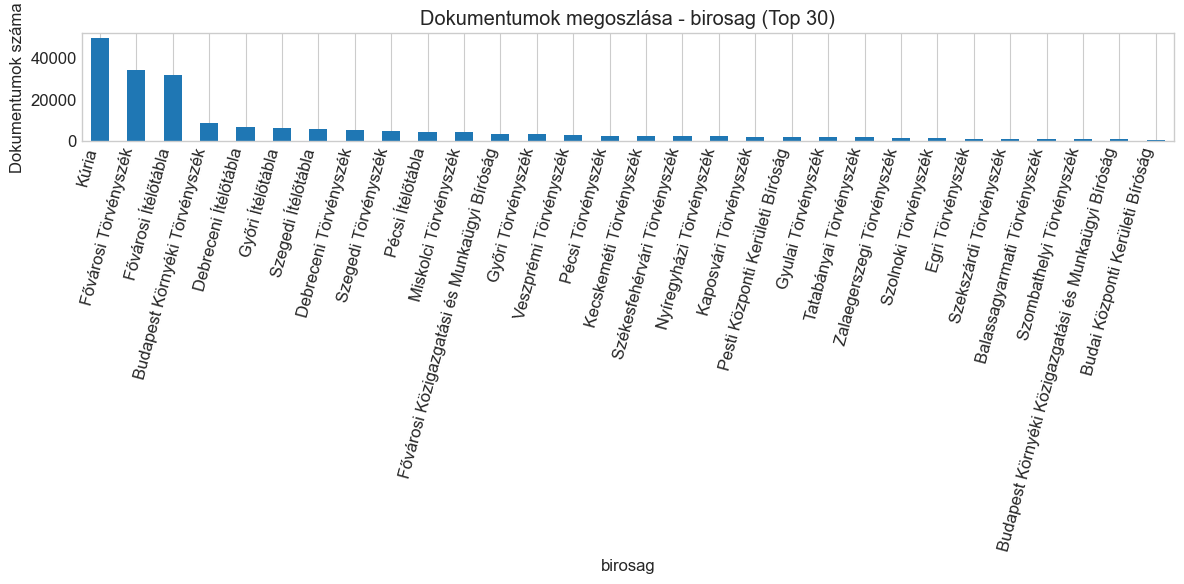


'JogTerulet' egyedi értékeinek száma: 8
Leggyakoribb 20 érték:


JogTerulet
polgári jog                  84840
közigazgatási jog            50158
büntetőjog                   34604
gazdasági jog                25312
munkaügy                     18556
katonai büntetőjog            2856
szabálysértési jog              27
büntetés-végrehajtási ügy        6
Name: count, dtype: int64

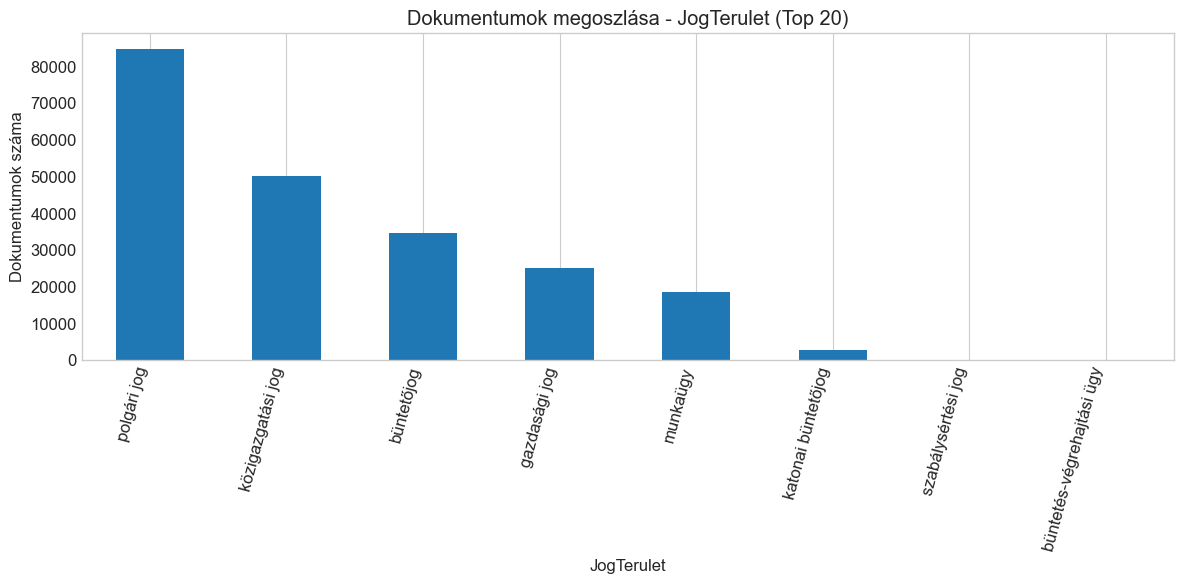


Érvényes 'HatarozatEve' értékek száma (2005 óta): 216171
Érvénytelen vagy hiányzó 'HatarozatEve' értékek száma: 471


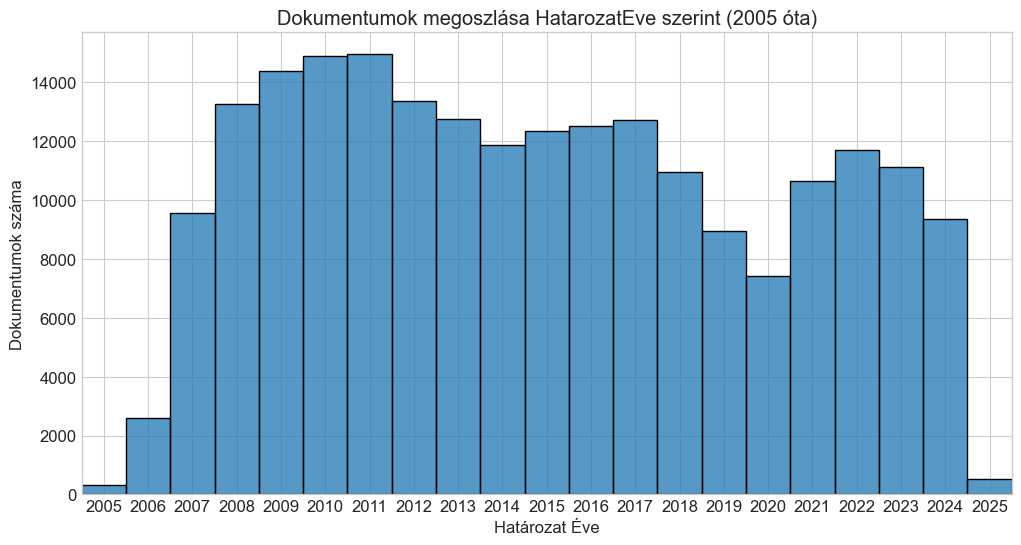

In [6]:
def plot_top_categories(df, column_name, top_n=20):
    """Segédfüggvény a leggyakoribb kategóriák megjelenítésére."""
    if column_name not in df.columns:
        print(f"Hiba: '{column_name}' oszlop nem található.")
        return

    counts = df[column_name].value_counts()
    print(f"\n'{column_name}' egyedi értékeinek száma: {counts.nunique()}")
    print(f"Leggyakoribb {top_n} érték:")
    display(counts.head(top_n))

    plt.figure(figsize=(12, 6))
    counts.head(top_n).plot(kind='bar')
    plt.title(f'Dokumentumok megoszlása - {column_name} (Top {top_n})')
    plt.xlabel(column_name)
    plt.ylabel('Dokumentumok száma')
    plt.xticks(rotation=75, ha='right')
    plt.grid(axis='y')
    plt.tight_layout() # Ensure labels fit
    plt.show()

if 'df' in locals():
    # Bíróság elemzése
    plot_top_categories(df, 'birosag', top_n=30)

    # Jogterület elemzése
    # Megjegyzés: A JogTerulet lehet komplex (pl. lista). A preprocess script stringgé alakítja.
    # Ha mégsem, akkor itt további tisztításra lehet szükség.
    plot_top_categories(df, 'JogTerulet', top_n=20)

    # HatarozatEve elemzése
    if 'HatarozatEve' in df.columns:
        # Érvényes évszámok szűrése (pl. 2005-től napjainkig) és integer típussá alakítás
        # Use Int64 to handle potential NaNs while keeping integer type
        df['HatarozatEve_num'] = pd.to_numeric(df['HatarozatEve'], errors='coerce').astype('Int64')
        valid_years_mask = (df['HatarozatEve_num'] >= 2005) & (df['HatarozatEve_num'] <= pd.Timestamp.now().year)
        valid_years = df.loc[valid_years_mask, 'HatarozatEve_num']

        print(f"\nÉrvényes 'HatarozatEve' értékek száma (2005 óta): {len(valid_years)}")
        print(f"Érvénytelen vagy hiányzó 'HatarozatEve' értékek száma: {len(df) - len(valid_years)}")

        if not valid_years.empty:
            plt.figure(figsize=(12, 6))
            # Use discrete=True for integer years to center bars on ticks
            min_year = valid_years.min()
            max_year = valid_years.max()
            # Let histplot handle bins for discrete data
            sns.histplot(x=valid_years, kde=False, discrete=True)
            plt.title('Dokumentumok megoszlása HatarozatEve szerint (2005 óta)')
            plt.xlabel('Határozat Éve')
            plt.ylabel('Dokumentumok száma')
            # Ensure ticks are placed at integer years
            tick_step = max(1, (max_year - min_year) // 20) # Adjust step for readability
            plt.xticks(ticks=range(min_year, max_year + 1, tick_step), rotation=0) # Set rotation to 0 for clarity if possible
            plt.xlim(min_year - 0.5, max_year + 0.5) # Keep slight padding
            plt.grid(True)
            plt.show()
        else:
            print("\n'HatarozatEve' oszlop nem található vagy nincsenek érvényes évszámok 2005 óta.")

## 5.1. Bíróság és Jogterület Kapcsolata


Bíróság és Jogterület kapcsolata:


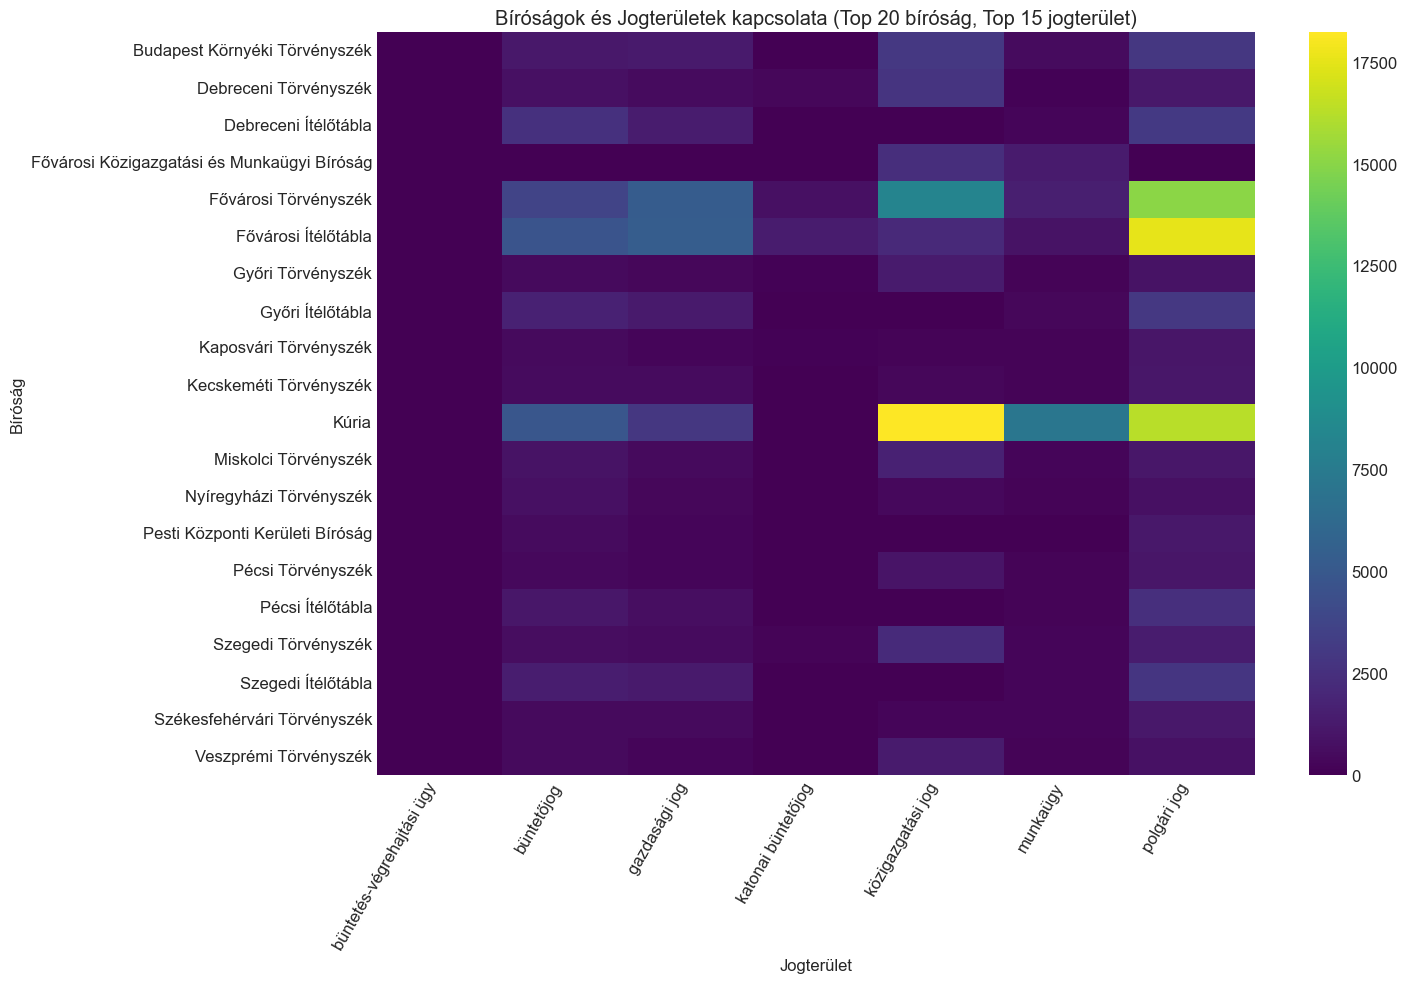

In [7]:
if 'df' in locals() and 'birosag' in df.columns and 'JogTerulet' in df.columns:
    print("\nBíróság és Jogterület kapcsolata:")
    top_n_birosag = 20
    top_m_jogterulet = 15
    top_birosagok = df['birosag'].value_counts().nlargest(top_n_birosag).index
    top_jogteruletek = df['JogTerulet'].value_counts().nlargest(top_m_jogterulet).index
    df_filtered = df[df['birosag'].isin(top_birosagok) & df['JogTerulet'].isin(top_jogteruletek)]
    if not df_filtered.empty:
        crosstab_bj = pd.crosstab(df_filtered['birosag'], df_filtered['JogTerulet'])
        plt.figure(figsize=(15, 10))
        sns.heatmap(crosstab_bj, cmap="viridis", annot=False, fmt="d")
        plt.title(f'Bíróságok és Jogterületek kapcsolata (Top {top_n_birosag} bíróság, Top {top_m_jogterulet} jogterület)')
        plt.xlabel('Jogterület')
        plt.ylabel('Bíróság')
        plt.xticks(rotation=60, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Nem található elég adat a szűrt bíróságokhoz és jogterületekhez a kereszttábla elkészítéséhez.")

## 5.2. Szöveghossz és Kategóriák

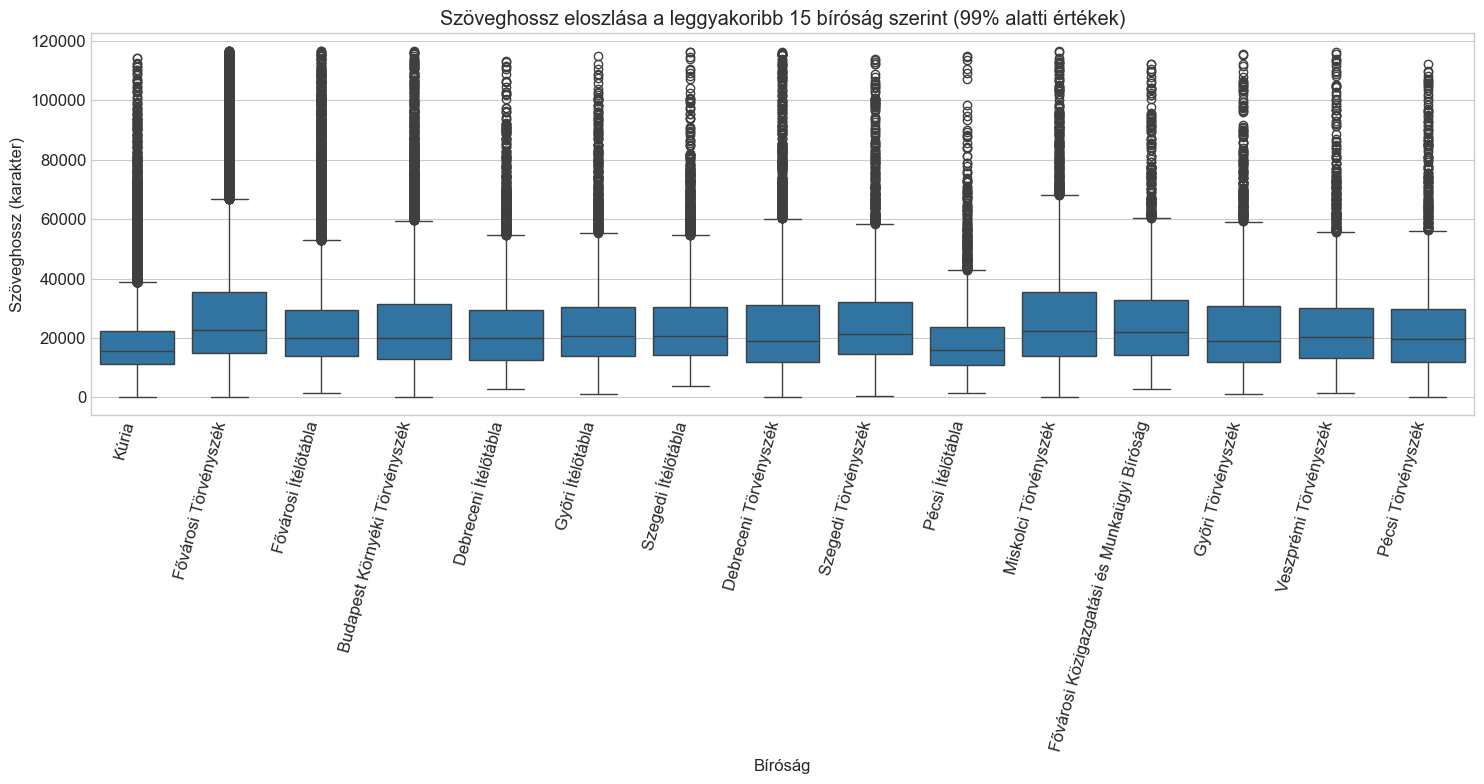

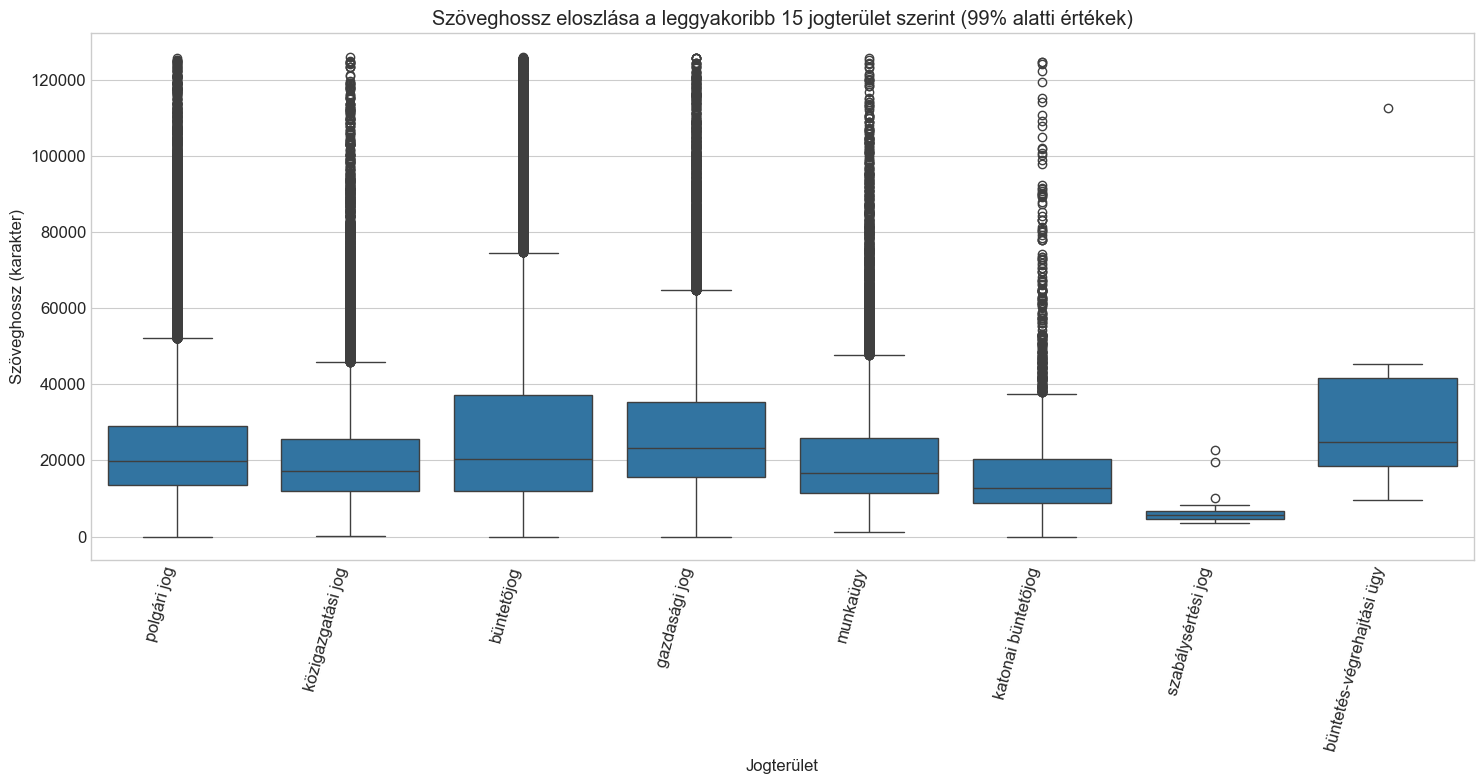

In [8]:
if 'df' in locals() and 'text_length' in df.columns:
    top_n = 15
    if 'birosag' in df.columns:
        top_birosagok = df['birosag'].value_counts().nlargest(top_n).index
        df_filtered_birosag = df[df['birosag'].isin(top_birosagok)]
        quantile_99 = df_filtered_birosag['text_length'].quantile(0.99)
        df_plot_birosag = df_filtered_birosag[df_filtered_birosag['text_length'] < quantile_99]
        plt.figure(figsize=(15, 8))
        sns.boxplot(data=df_plot_birosag, x='birosag', y='text_length', order=top_birosagok)
        plt.title(f'Szöveghossz eloszlása a leggyakoribb {top_n} bíróság szerint (99% alatti értékek)')
        plt.xlabel('Bíróság')
        plt.ylabel('Szöveghossz (karakter)')
        plt.xticks(rotation=75, ha='right')
        plt.tight_layout()
        plt.show()
    if 'JogTerulet' in df.columns:
        top_jogteruletek = df['JogTerulet'].value_counts().nlargest(top_n).index
        df_filtered_jogterulet = df[df['JogTerulet'].isin(top_jogteruletek)]
        quantile_99_jt = df_filtered_jogterulet['text_length'].quantile(0.99)
        df_plot_jogterulet = df_filtered_jogterulet[df_filtered_jogterulet['text_length'] < quantile_99_jt]
        plt.figure(figsize=(15, 8))
        sns.boxplot(data=df_plot_jogterulet, x='JogTerulet', y='text_length', order=top_jogteruletek)
        plt.title(f'Szöveghossz eloszlása a leggyakoribb {top_n} jogterület szerint (99% alatti értékek)')
        plt.xlabel('Jogterület')
        plt.ylabel('Szöveghossz (karakter)')
        plt.xticks(rotation=75, ha='right')
        plt.tight_layout()
        plt.show()

## 5.3. Időbeli Trendek


Jogterületek gyakoriságának változása az évek során:


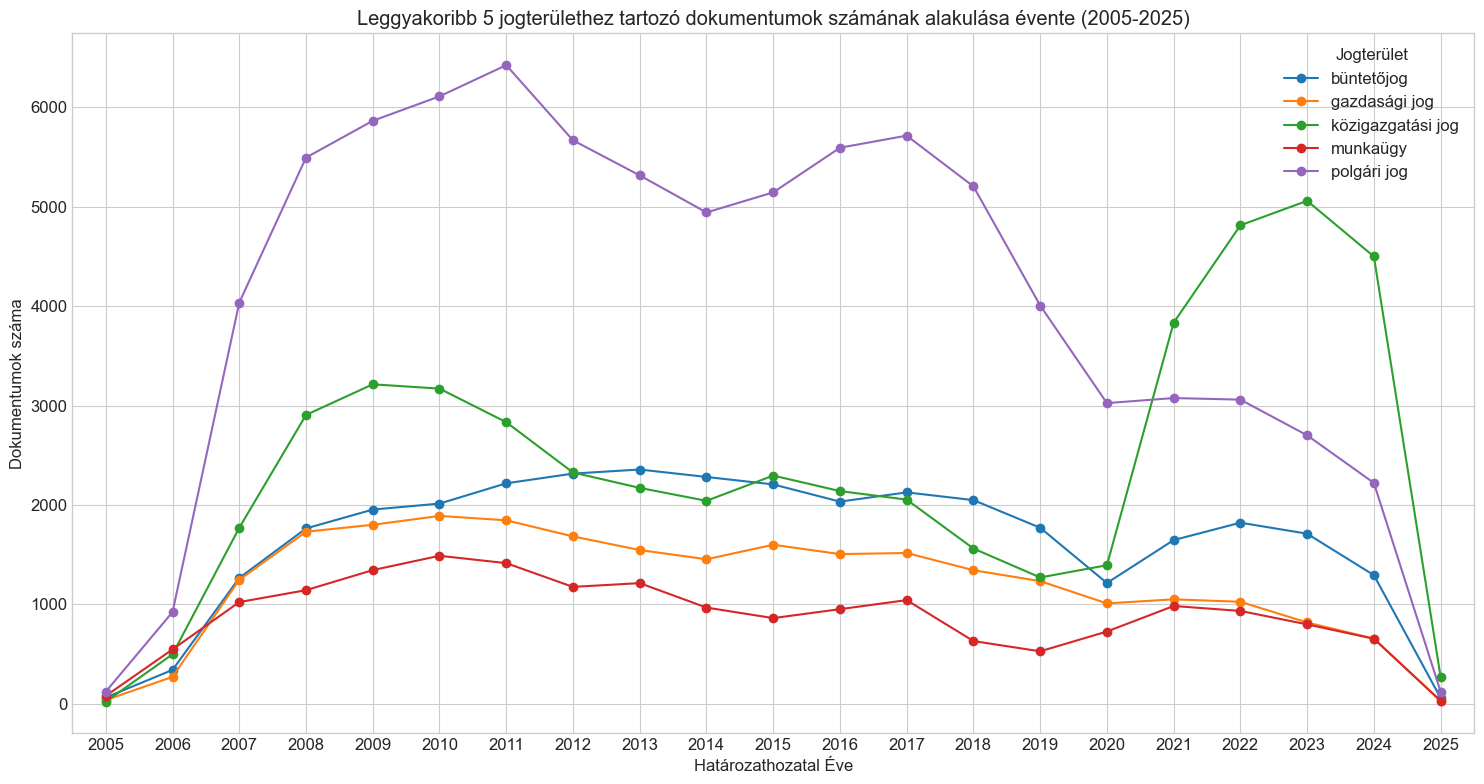

In [9]:
if 'df' in locals() and 'HatarozatEve_num' in df.columns and 'JogTerulet' in df.columns:
    print("\nJogterületek gyakoriságának változása az évek során:")
    # Ensure HatarozatEve_num is Int64 before filtering
    if not pd.api.types.is_integer_dtype(df['HatarozatEve_num']):
         df['HatarozatEve_num'] = pd.to_numeric(df['HatarozatEve'], errors='coerce').astype('Int64')

    min_analysis_year = 2005
    current_year = pd.Timestamp.now().year
    valid_years_mask = (df['HatarozatEve_num'] >= min_analysis_year) & (df['HatarozatEve_num'] <= current_year)
    top_m_jogterulet = 5
    top_jogteruletek = df['JogTerulet'].value_counts().nlargest(top_m_jogterulet).index
    df_filtered_time = df[valid_years_mask & df['JogTerulet'].isin(top_jogteruletek)].copy()

    if not df_filtered_time.empty:
        trends = df_filtered_time.groupby(['HatarozatEve_num', 'JogTerulet']).size().unstack(fill_value=0)
        plt.figure(figsize=(15, 8))
        trends.plot(kind='line', marker='o', ax=plt.gca()) # Added marker for clarity
        plt.title(f'Leggyakoribb {top_m_jogterulet} jogterülethez tartozó dokumentumok számának alakulása évente ({min_analysis_year}-{current_year})')
        plt.xlabel('Határozathozatal Éve')
        plt.ylabel('Dokumentumok száma')
        plt.xticks(range(min_analysis_year, current_year + 1, max(1, (current_year - min_analysis_year) // 15))) # Adjust tick frequency
        plt.xlim(min_analysis_year - 0.5, current_year + 0.5) # Adjust xlim slightly
        plt.legend(title='Jogterület')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Nem található elég adat a top {top_m_jogterulet} jogterület időbeli trendjének vizsgálatához {min_analysis_year} óta.")

## 6. Azonosítók Elemzése

In [10]:
if 'df' in locals():
    for id_col in ['doc_id', 'Azonosito', 'EgyediAzonosito']:
        if id_col in df.columns:
            print(f"\n'{id_col}' elemzése:")
            uniqueness = df[id_col].nunique()
            total_rows = len(df)
            duplicates = total_rows - uniqueness
            print(f"  Összes sor: {total_rows}")
            print(f"  Egyedi értékek: {uniqueness}")
            print(f"  Duplikált értékek (vagy hiányzó): {duplicates}")
            if duplicates > 0:
                duplicated_ids = df[df.duplicated(subset=[id_col], keep=False)][id_col].value_counts()
                print(f"  Leggyakoribb duplikált/hiányzó '{id_col}' értékek:")
                display(duplicated_ids[duplicated_ids > 1].head())
        else:
            print(f"\n'{id_col}' oszlop nem található.")


'doc_id' elemzése:
  Összes sor: 216642
  Egyedi értékek: 213419
  Duplikált értékek (vagy hiányzó): 3223
  Leggyakoribb duplikált/hiányzó 'doc_id' értékek:


doc_id
Pf.20200/2017/6    4
Pf.20075/2017/4    4
Pf.20154/2018/4    4
Pf.20009/2024/4    4
Pf.20250/2017/4    3
Name: count, dtype: int64


'Azonosito' elemzése:
  Összes sor: 216642
  Egyedi értékek: 213137
  Duplikált értékek (vagy hiányzó): 3505
  Leggyakoribb duplikált/hiányzó 'Azonosito' értékek:


Azonosito
Pf.20200/2017/6    4
Pf.20075/2017/4    4
Pf.20154/2018/4    4
Pf.20009/2024/4    4
Pf.20250/2017/4    3
Name: count, dtype: int64


'EgyediAzonosito' elemzése:
  Összes sor: 216642
  Egyedi értékek: 214104
  Duplikált értékek (vagy hiányzó): 2538
  Leggyakoribb duplikált/hiányzó 'EgyediAzonosito' értékek:


EgyediAzonosito
PIT-BJ-2020-1    2
1-KJ-2020-12     2
1-KJ-2020-58     2
1-KJ-2020-7      2
1-KJ-2020-37     2
Name: count, dtype: int64

## 7. Kapcsolódó Határozatok Elemzése


'KapcsolodoHatarozatok' elemzése:
  Dokumentumok száma kapcsolódó határozattal (nem üres lista/nem NaN): 177052
  Dokumentumok száma kapcsolódó határozat nélkül (NaN vagy '[]'): 39590

'Kapcsolódó Bíróság' egyedi értékeinek száma: 235
Leggyakoribb 20 érték:


Kapcsolódó Bíróság
["Fővárosi Törvényszék"]                           22238
["Fővárosi Ítélőtábla"]                            21490
["Kúria"]                                          13477
["Budapest Környéki Törvényszék"]                   5006
["Kúria", "Fővárosi Törvényszék"]                   4653
["Győri Ítélőtábla"]                                4092
["Debreceni Ítélőtábla"]                            3973
["Szegedi Ítélőtábla"]                              3963
["Kúria", "Fővárosi Ítélőtábla"]                    2981
["Fővárosi Ítélőtábla", "Fővárosi Törvényszék"]     2864
["Pécsi Ítélőtábla"]                                2720
["Fővárosi Törvényszék", "Kúria"]                   2667
["Fővárosi Közigazgatási és Munkaügyi Bíróság"]     2636
["Debreceni Törvényszék"]                           2407
["Miskolci Törvényszék"]                            2401
["Szegedi Törvényszék"]                             2393
["Kecskeméti Törvényszék"]                          1978
["Székesfehé

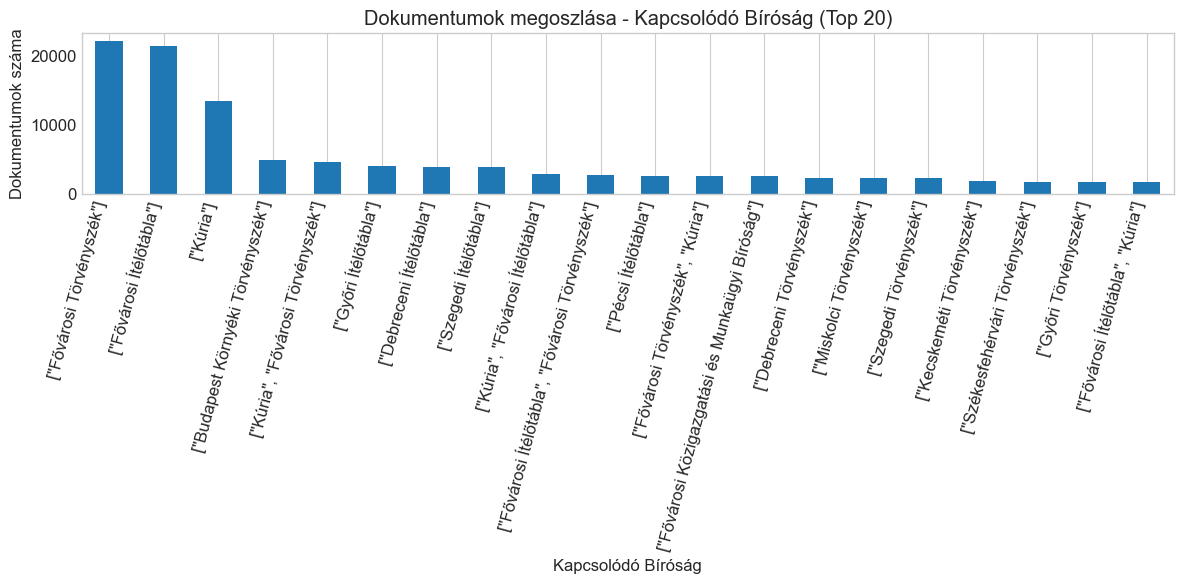


'Kapcsolódó Ügyszám' elemzése:
  Dokumentumok száma első kapcsolódó ügyszámmal: 177052
  Dokumentumok száma első kapcsolódó ügyszám nélkül: 39590

'Kapcsolódó Ügyszám' egyedi értékeinek száma: 4
Leggyakoribb 20 érték:


Kapcsolódó Ügyszám
["Pf.20966/2009/4"]    4
["Pf.20427/2007/4"]    4
["Bf.100/2011/4"]      4
["Pf.21358/2010/3"]    4
["Bf.208/2013/12"]     3
["Pf.20138/2009/5"]    3
["Bf.4/2012/6"]        3
["Pf.20136/2013/9"]    3
["Pf.20516/2008/4"]    3
["Pf.20019/2024/4"]    3
["Pf.20154/2018/4"]    3
["Pf.20234/2010/4"]    3
["Pf.20059/2017/5"]    3
["Pf.20441/2007/4"]    3
["Pf.20218/2010/5"]    3
["Bf.203/2010/5"]      3
["Pf.20437/2010/4"]    3
["K.27407/2016/5"]     3
["Pf.20076/2017/4"]    3
["Pf.20332/2010/4"]    3
Name: count, dtype: int64

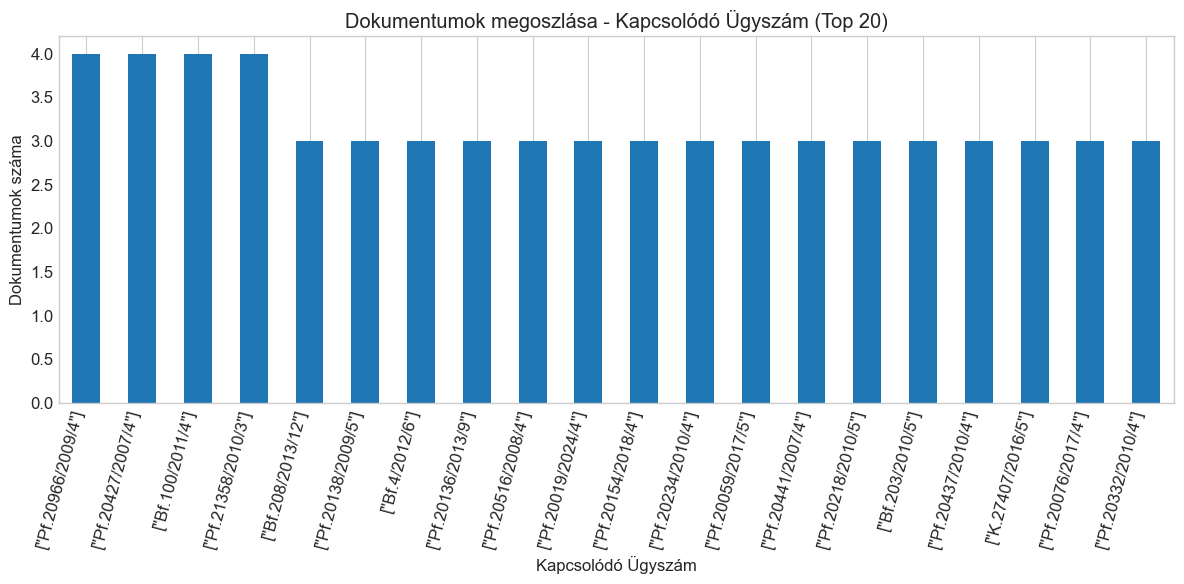

In [11]:
if 'df' in locals():
    # KapcsolodoHatarozatok (JSON stringként tárolva)
    if 'KapcsolodoHatarozatok' in df.columns:
        print("\n'KapcsolodoHatarozatok' elemzése:")
        # Számoljuk, hány rekordnak van nem-üres/nem-null kapcs. hat. listája
        # Feltételezzük, hogy a preprocess script NaN-t, '[]'-t vagy más stringet/listát menthet
        # Ez a sor ellenőrzi, hogy az érték nem NaN ÉS nem az üres lista string reprezentációja
        has_related = df['KapcsolodoHatarozatok'].notna() & (df['KapcsolodoHatarozatok'] != '[]')
        print(f"  Dokumentumok száma kapcsolódó határozattal (nem üres lista/nem NaN): {has_related.sum()}")
        print(f"  Dokumentumok száma kapcsolódó határozat nélkül (NaN vagy '[]'): {len(df) - has_related.sum()}")
    else:
        print("\n'KapcsolodoHatarozatok' oszlop nem található.")

    # Első kapcsolódó bíróság elemzése
    if 'Kapcsolódó Bíróság' in df.columns:
        plot_top_categories(df, 'Kapcsolódó Bíróság', top_n=20)
    else:
        print("\n'Kapcsolódó Bíróság' oszlop nem található.")

    # Első kapcsolódó ügyszám elemzése
    if 'Kapcsolódó Ügyszám' in df.columns:
        print("\n'Kapcsolódó Ügyszám' elemzése:")
        # Először csak a jelenlétét nézzük
        has_all_ugyszam = df['Kapcsolódó Ügyszám'].notna().sum()
        print(f"  Dokumentumok száma első kapcsolódó ügyszámmal: {has_all_ugyszam}")
        print(f"  Dokumentumok száma első kapcsolódó ügyszám nélkül: {len(df) - has_all_ugyszam}")
        # Most vizualizáljuk a leggyakoribb ügyszámokat
        plot_top_categories(df, 'Kapcsolódó Ügyszám', top_n=20)
    else:
        print("\n'Kapcsolódó Ügyszám' oszlop nem található.")

## 7.1. Jogszabályhelyek Mélyebb Elemzése


'Jogszabalyhelyek' elemzése:

Diagnosztika: Első 10 nem-üres/nem-'[]' Jogszabalyhelyek érték:
  1: Type=<class 'str'>, Value='1998. évi XIX. törvény a büntetőeljárásról 348. § - 2008-06-02;</br>1998. évi XIX. törvény a büntetőeljárásról 4. § - 2008-06-02;</br>1998. évi XIX. törvény a büntetőeljárásról 111. § - 2008-06-02;</br>1978. évi IV. törvény a Büntető Törvénykönyvről 166. § - 2008-06-02;</br>1978. évi IV. törvény a Büntető Törvénykönyvről 87. § - 2008-06-02;</br>1978. évi IV. törvény a Büntető Törvénykönyvről 45. § - 2008-06-02;</br>1998. évi XIX. törvény a büntetőeljárásról 155. § - 2008-06-02;</br>1998. évi XIX. törvény a büntetőeljárásról 403. § - 2008-06-02;</br>1998. évi XIX. törvény a büntetőeljárásról 339. § - 2008-06-02;</br>1998. évi XIX. törvény a büntetőeljárásról 372. § - 2008-06-02;</br>1998. évi XIX. törvény a büntetőeljárásról 371. § - 2008-06-02;</br>1998. évi XIX. törvény a büntetőeljárásról 372. § (1);</br>1978. évi IV. törvény a Büntető Törvénykönyvről 166. § 

parsed_jogszabalyhelyek
1952. évi III. törvény a polgári perrendtartásról 78. § (1);                                            87887
32/2003. (VIII. 22.) IM rendelet a bírósági eljárásban megállapítható ügyvédi költségekről 3. § (2);    42854
1952. évi III. törvény a polgári perrendtartásról 253. § (2);                                           40882
6/1986. (VI. 26.) IM rendelet a költségmentesség alkalmazásáról a bírósági eljárásban 13. § (2);        39086
32/2003. (VIII. 22.) IM rendelet a bírósági eljárásban megállapítható ügyvédi költségekről 3. § (5);    32515
6/1986. (VI. 26.) IM rendelet a költségmentesség alkalmazásáról a bírósági eljárásban 14. §;            27776
1952. évi III. törvény a polgári perrendtartásról 164. § (1);                                           27492
1952. évi III. törvény a polgári perrendtartásról 206. § (1);                                           27052
1952. évi III. törvény a polgári perrendtartásról 275. § (3);                                   

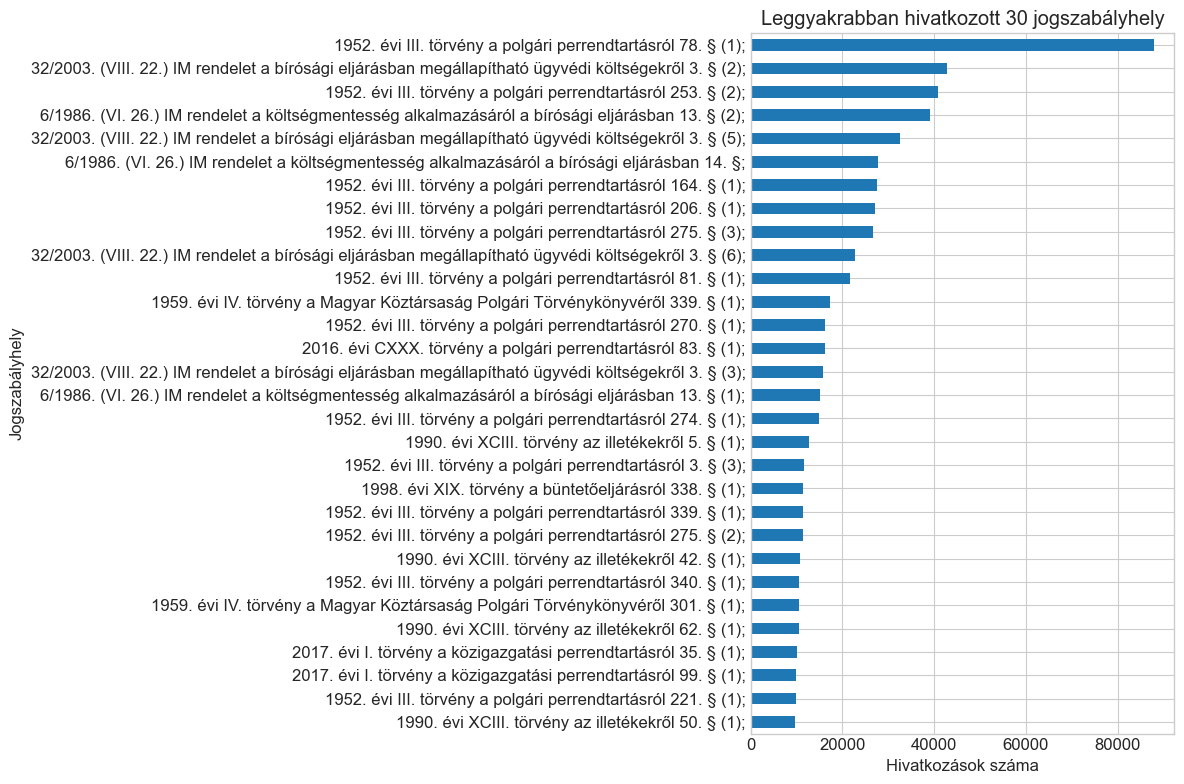

In [12]:
import ast
if 'df' in locals() and 'Jogszabalyhelyek' in df.columns:
    print("\n'Jogszabalyhelyek' elemzése:")

    # --- DIAGNOSZTICA START ---
    print("\nDiagnosztika: Első 10 nem-üres/nem-'[]' Jogszabalyhelyek érték:")
    sample_values = df[df['Jogszabalyhelyek'].notna() & (df['Jogszabalyhelyek'] != '[]')]['Jogszabalyhelyek'].head(10)
    if not sample_values.empty:
        for i, val in enumerate(sample_values):
            print(f"  {i+1}: Type={type(val)}, Value='{val}'")
    else:
        print("  Nem található minta a diagnosztikához (minden érték NaN vagy '[]').")
    print("--- DIAGNOSZTICA END ---\n")
    # --- END DIAGNOSTICS ---

    def parse_jogszabaly(value):
        if pd.isna(value) or not isinstance(value, str) or value.strip() == '[]' or not value.strip():
            return []
        try:
            # Darabolás a '</br>' mentén, majd felesleges szóközök eltávolítása
            items = value.split('</br>')
            # Üres elemek kiszűrése és szóközök eltávolítása az elemek elejéről/végéről
            cleaned_items = [item.strip() for item in items if item.strip()]
            return cleaned_items
        except Exception as e:
            # Váratlan hiba esetén is üres listát adunk vissza
            print(f"Hiba a jogszabályhely feldolgozása közben: {e}, Érték: {value}")
            return []

    df['parsed_jogszabalyhelyek'] = df['Jogszabalyhelyek'].apply(parse_jogszabaly)
    jogszabaly_series = df['parsed_jogszabalyhelyek'].explode().dropna()
    print(f"\nÖsszesen {len(jogszabaly_series)} jogszabályhely hivatkozás található (az összes dokumentumban).")
    if not jogszabaly_series.empty:
        jogszabaly_counts = jogszabaly_series.value_counts()
        print(f"\nEgyedi jogszabályhelyek száma: {len(jogszabaly_counts)}")
        top_n = 30
        print(f"\nLeggyakrabban hivatkozott {top_n} jogszabályhely:")
        display(jogszabaly_counts.head(top_n))
        plt.figure(figsize=(12, 8))
        jogszabaly_counts.head(top_n).plot(kind='barh')
        plt.title(f'Leggyakrabban hivatkozott {top_n} jogszabályhely')
        plt.xlabel('Hivatkozások száma')
        plt.ylabel('Jogszabályhely')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("Nem található érvényes jogszabályhely hivatkozás az elemzéshez.")

## 8. Duplikált Szövegek Elemzése

In [13]:
if 'df' in locals() and 'text' in df.columns:
    print("\nDuplikált szövegek keresése:")
    # Üres stringeket és NaN-okat figyelmen kívül hagyjuk a duplikátumkeresésnél
    non_empty_texts = df[df['text'].fillna('').astype(str).str.len() > 0]['text']
    duplicates_count = non_empty_texts.duplicated().sum()
    print(f"{duplicates_count} duplikált (nem üres) szöveg található.")

    if duplicates_count > 0:
        duplicated_texts = df[df.duplicated(subset=['text'], keep=False) & (df['text'].fillna('').astype(str).str.len() > 0)]
        print("Példák duplikált szövegekre (max 5 csoport):")
        # Csoportosítjuk a duplikált szövegek alapján és kiírjuk az ID-kat
        grouped_duplicates = duplicated_texts.groupby('text')['doc_id'].apply(list)
        display(grouped_duplicates.head(5))


Duplikált szövegek keresése:
26 duplikált (nem üres) szöveg található.
Példák duplikált szövegekre (max 5 csoport):


text
<html><body><h1>504 Gateway Time-out</h1>The server didn't respond in time.</body></html>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

## 9. Összegzés és Következtetések

Az EDA során feltárt főbb megállapítások:
- **Adatmennyiség:** Összesen X dokumentum került betöltésre Y oszloppal.
- **Hiányzó adatok:** Jelentős hiányosságok figyelhetők meg a Z, W, ... oszlopokban. Ezek kezelése szükséges lehet a további elemzésekhez.
- **Szöveghossz:** A szövegek hossza változó, átlagosan K karakter. Néhány kiugróan hosszú/rövid dokumentum található.
- **Bíróságok:** A legtöbb dokumentum az A, B, C bíróságoktól származik.
- **Jogterületek:** A leggyakoribb jogterületek a D, E, F.
- **Évek:** A határozatok évei T1 és T2 között szóródnak leginkább.
- **Azonosítók:** Az [doc_id/Azonosito/EgyediAzonosito] egyedisége [megfelelő/nem megfelelő]. Duplikátumok [vannak/nincsenek].
- **Kapcsolódó ügyek:** A dokumentumok P százalékához tartozik kapcsolódó ügy.
- **Duplikátumok:** R darab duplikált szövegű dokumentumot találtunk.

**Javasolt következő lépések:**
- Hiányzó adatok kezelése (imputáció, sorok törlése).
- Rövid/üres szövegek eltávolítása vagy további vizsgálata.
- Duplikált szövegek kezelése (egyedi megtartása).
- Kategorikus változók további vizsgálata, esetleges összevonása.
- Szövegtisztítás és normalizálás (pl. írásjelek, kisbetűsítés, stoppszavak).
- Mélyebb szövegelemzés (pl. N-grammok, téma modellezés).

In [14]:
# Ez a cella üresen hagyható, vagy további kísérletezésre használható.
print("\nEDA futás befejezve.")


EDA futás befejezve.
